In [4]:
import sys
sys.path.append('../Data_Feature')
sys.path.append('../Datasets')
print(sys.path)
import numpy as np
import os
import requests
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB # or GaussianNB if your data is normalized and continuous
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, make_scorer, matthews_corrcoef, roc_curve, auc
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
import plotly.figure_factory as ff
import networkx as nx
from pyvis.network import Network
from pyvis.network import Network
'''from goatools.obo_parser import GODag
from goatools.base import get_godag
from goatools.gosubdag.gosubdag import GoSubDag'''
from bioservices import KEGG
import zipfile 


'''
Data prep and feature mapping
'''

# Paths to your uploaded files
zip_file_path_GO = "C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/terms_GO.zip"
csv_file_name_GO = 'terms_GO.csv'
zip_file_path_traits = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/reducedDataset.zip'
csv_file_name_traits = 'reducedDataset.csv'
# Read and preprocess KO terms
with zipfile.ZipFile(zip_file_path_GO, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_GO) as file:
        GOs = pd.read_csv(file, index_col=0)

GOs['value'] = 1
X_terms = GOs.pivot_table(index='key', columns='GO', values='value', fill_value=0)
#X_terms = X_terms[['GO:0009060','GO:0009061']] # Theory, a game theroty


# Apply VarianceThreshold to remove constant features
selector = VarianceThreshold(threshold=0.02)
X_filtered = selector.fit_transform(X_terms)
X_filtered_df = pd.DataFrame(X_filtered, index=X_terms.index, columns=X_terms.columns[selector.get_support()])

# Optionally, inspect the variance of features to confirm removal
feature_variances = X_filtered_df.var()
print(f"Features with zero variance after filtering: {sum(feature_variances == 0)}")

# Read and preprocess traits data
with zipfile.ZipFile(zip_file_path_traits, 'r') as zip_ref:
    with zip_ref.open(csv_file_name_traits) as file:
        traits = pd.read_csv(file, sep=';')
traits['oxygen'] = traits['oxygen'].str.lower()

# Mapping of oxygen levels to a simplified classification
oxygen_mapping = {
    'aerobic': 'aerobic',
    'aerotolerant': 'aerobic',
    'microaerophilic': 'aerobic',
    'obligate aerobic': 'aerobic',
    'anaerobic': 'anaerobic',
    'obligate anaerobic': 'anaerobic',
    'conflict': 'aerobic',  
    'facultative': 'aerobic'  
}
traits['oxygen'] = traits['oxygen'].map(oxygen_mapping)


# Handling missing values and aggregating by key
y = traits.dropna(subset=['oxygen']).groupby('key').agg({'oxygen': lambda x: x.value_counts().index[0]})

# Find common keys after removing missing values
common_keys = X_filtered_df.index.intersection(y.index)

# Align X (features) and Y (labels) based on common keys
X_aligned = X_filtered_df.loc[common_keys]
Y_aligned = y.loc[common_keys].values.ravel()

# Ensures X_aligned and Y_aligned are aligned
assert X_aligned.shape[0] == len(Y_aligned), "X and Y are not aligned"



['c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313\\python313.zip', 'c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313\\DLLs', 'c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313\\Lib', 'c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313', '', 'C:\\Users\\eliah\\AppData\\Roaming\\Python\\Python313\\site-packages', 'C:\\Users\\eliah\\AppData\\Roaming\\Python\\Python313\\site-packages\\win32', 'C:\\Users\\eliah\\AppData\\Roaming\\Python\\Python313\\site-packages\\win32\\lib', 'C:\\Users\\eliah\\AppData\\Roaming\\Python\\Python313\\site-packages\\Pythonwin', 'c:\\Users\\eliah\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages', '../Data_Feature', '../Datasets', '../Data_Feature', '../Datasets', '../Data_Feature', '../Datasets', '../Data_Feature', '../Datasets']
Features with zero variance after filtering: 0


In [2]:
X_terms.sum(axis=1).value_counts()

2093.0    7
2346.0    6
2069.0    6
1995.0    6
343.0     6
         ..
726.0     1
198.0     1
2541.0    1
1183.0    1
133.0     1
Name: count, Length: 1954, dtype: int64

GO   GO:0000003  GO:0000006  GO:0000009  GO:0000014  GO:0000015  GO:0000018  \
key                                                                           
1           1.0         0.0         0.0         0.0         0.0         0.0   
2           1.0         0.0         0.0         0.0         0.0         0.0   
3           0.0         0.0         0.0         0.0         0.0         0.0   
4           0.0         0.0         0.0         0.0         0.0         0.0   
5           1.0         0.0         0.0         0.0         0.0         0.0   

GO   GO:0000023  GO:0000025  GO:0000026  GO:0000027  ...  GO:2001241  \
key                                                  ...               
1           0.0         0.0         0.0         1.0  ...         0.0   
2           0.0         0.0         0.0         1.0  ...         0.0   
3           0.0         0.0         0.0         1.0  ...         0.0   
4           0.0         0.0         0.0         1.0  ...         0.0   
5           0.

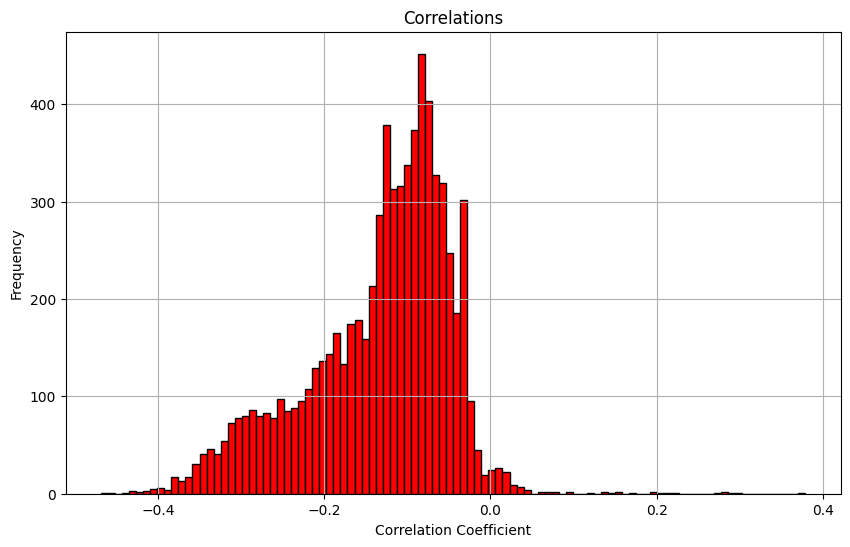

In [3]:
''' Calculating Pearsons coefficient'''

# Always look at data, right?
print(X_aligned.head())


'''Handelig data values'''

# Checking datatype for y_algned, i think
class_distribution = pd.Series(Y_aligned).value_counts()
print("Class distribution in Y_aligned:", class_distribution)

# Checks data label of Y algined
unique_labels = np.unique(Y_aligned)
print(f"Unique labels in Y_aligned: {unique_labels}")

# Initialize the LabelEncoder and transform the data from catagorical
label_encoder = LabelEncoder()
Y_aligned = label_encoder.fit_transform(Y_aligned)

# Check data once labelencoder is done
print(f"Data of Y_aligned: {np.unique(Y_aligned)}")


# Calculate Pearson correlation coefficients
corr_coefficients = [] # Collectes coefficents from X_aligned and Y_aligned calculations

# I should probably check how pearsons actually works


for column in X_aligned.columns: # Iterates over every column in X_aligned
    # Easier to check all the different collumns because its a pandas data frame
    # Interger indexing is cool but i dont like it
    r, p = pearsonr(X_aligned[column], Y_aligned)  
    corr_coefficients.append(r)


# PLotting
plt.figure(figsize=(10, 6))
plt.hist(corr_coefficients, bins=100, color='red', edgecolor='black')
plt.title('Correlations')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Fitting 5 folds for each of 189 candidates, totalling 945 fits
Best parameters found: {'estimator': SVC(random_state=42), 'estimator__C': 10, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf', 'select_k__k': 1000}
Best cross-validation score: 0.948
Matthews Correlation Coefficient: 0.7967472682257869


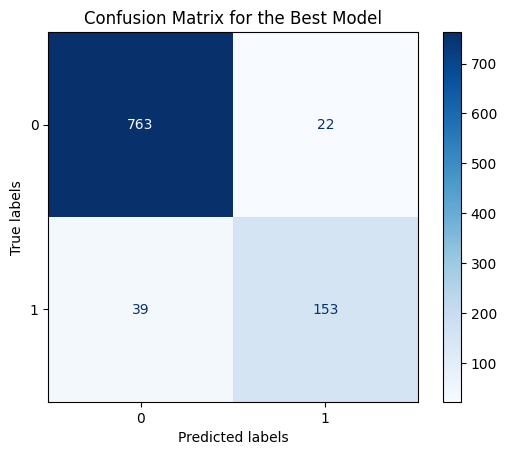

In [5]:
''' Pipeline implementation for Naive bayes and random forests'''

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_aligned, Y_aligned, test_size=0.3, random_state=42)

pipeline = Pipeline([
    ('select_k', SelectKBest(f_classif)),
    ('estimator', RandomForestClassifier())
])

# Define a parameter grid to search over
param_grid = [
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  # May need adjusting  100, 200, 300
        'estimator': [RandomForestClassifier(random_state=42)],
        'estimator__n_estimators': [100, 200],  
        'estimator__max_depth': [5, 10, None]  
    },
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  # May need adjusting  100, 200, 300
        'estimator': [SVC(random_state=42)],
        'estimator__C': [0.1, 1, 10],  
        'estimator__kernel': ['linear', 'rbf'], 
        'estimator__gamma': ['scale', 'auto']  
    },
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  # May need adjusting  100, 200, 300
        'estimator': [LogisticRegression()],
        'estimator__C': [0.01, 0.1, 1, 10, 100]
    },         
    {
        'select_k__k': [10, 50, 100, 200, 300, 500, 1000],  # May need adjusting  100, 200, 300
        'estimator': [BernoulliNB()],
        'estimator__alpha': [0.01, 0.1, 1.0, 10.0],  
        'estimator__binarize': [0.0]  # Is automatically applied
    }
]



''' Grid search '''

# Set up GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, Y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)


'''MCC shenanigans'''

mcc = matthews_corrcoef(Y_test, Y_pred)
print(f"Matthews Correlation Coefficient: {mcc}")


# Display confusion matrix for the best model
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix for the Best Model')
plt.show()


Most selected GO terms for predicting oxygen trait in hierchical manner based on randomforest classifier:
This is model based feature importance (uses models own feature importance score to evaluate most important ones)
Index(['GO:0042737', 'GO:0006563', 'GO:0034301', 'GO:0016054', 'GO:0051537',
       'GO:0051213', 'GO:0070403', 'GO:0016645', 'GO:0000096', 'GO:0004425'],
      dtype='object', name='GO')


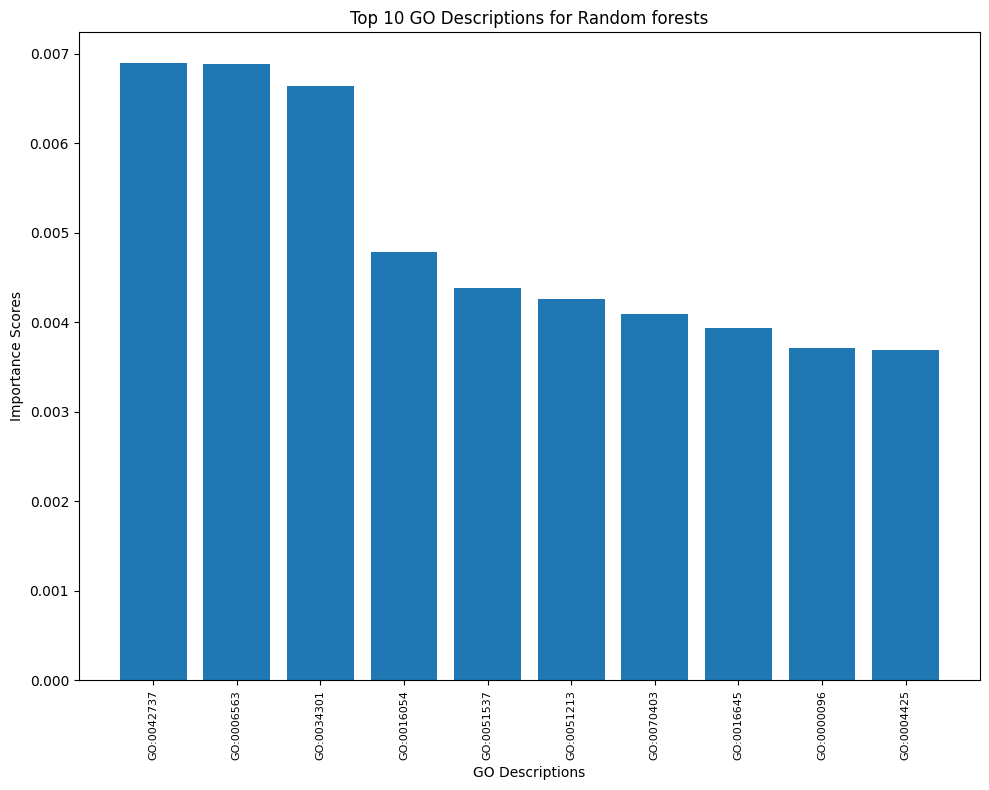

Most selected GO terms for predicting oxygen trait in hierchical manner based on logistic regression:
This is model based feature importance (uses model's coefficients as importance scores)
Index(['GO:0097657', 'GO:0042803', 'GO:0015297', 'GO:0016875', 'GO:0004812',
       'GO:0000179', 'GO:0004831', 'GO:0010038', 'GO:0003992', 'GO:0031669'],
      dtype='object', name='GO')


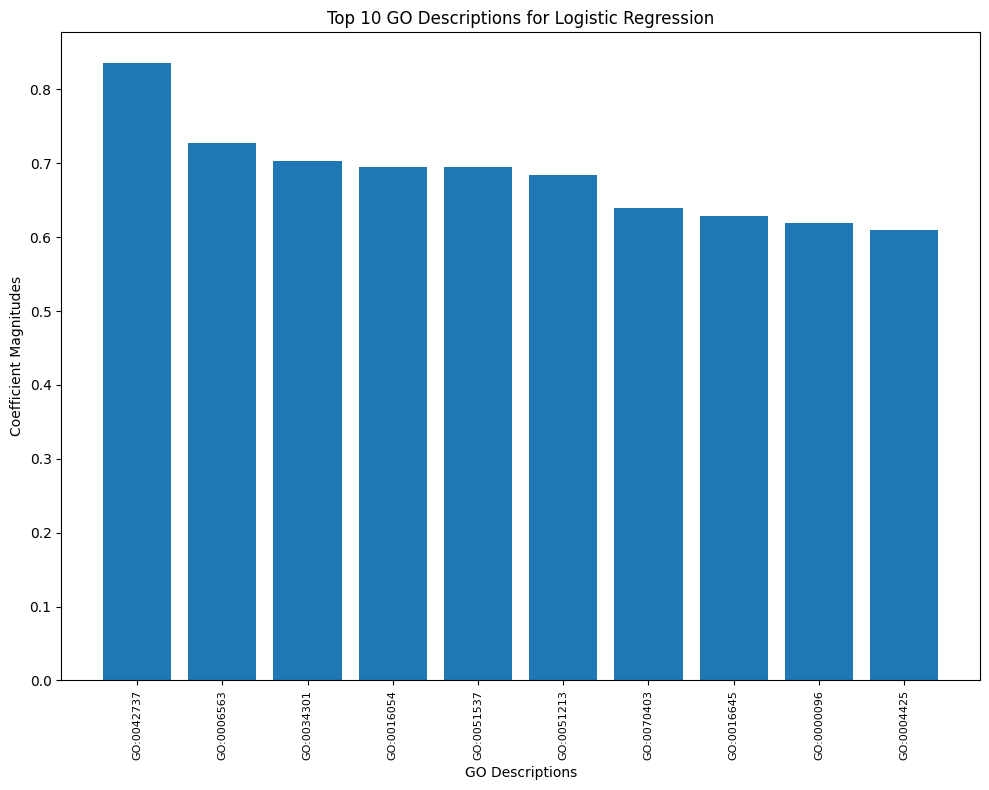

In [5]:
''' Model based feature importance score '''

#Fit a RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_aligned, Y_aligned)

#Rank features by their importances
feature_importances = model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

# Select the top 10 features
top_k_indices = sorted_indices[:10]
selected_features = X_aligned.columns[top_k_indices]

# Scores of selected features
sorted_scores = feature_importances[top_k_indices]

print("Most selected GO terms for predicting oxygen trait in hierchical manner based on randomforest classifier:")
print("This is model based feature importance (uses models own feature importance score to evaluate most important ones)")
print(selected_features)

#Translate selected GO terms to their descriptions
# Need to find translation thingy

# Prepare labels and scores for plotting
labels = selected_features
sorted_labels = [labels[idx] for idx in range(len(labels))]

# Plotting with translated names
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_labels)), sorted_scores)
plt.xticks(range(len(sorted_labels)), selected_features, rotation='vertical', fontsize=8)
plt.xlabel('GO Descriptions')
plt.ylabel('Importance Scores')
plt.title('Top 10 GO Descriptions for Random forests')
plt.tight_layout()
plt.show()


''' For logsitc regression'''

#Fit a LogisticRegression model
lr_model = LogisticRegression(solver="liblinear")
lr_model.fit(X_aligned, Y_aligned)

#Rank features by their coefficients
lr_coefficients = lr_model.coef_[0]
sorted_indices_lr = np.argsort(np.abs(lr_coefficients))[::-1]

# Select the top 10 features
top_k_indices_lr = sorted_indices_lr[:10]
selected_features_lr = X_aligned.columns[top_k_indices_lr]

# Coefficients (importance) of selected features
sorted_scores_lr = lr_coefficients[top_k_indices_lr]

print("Most selected GO terms for predicting oxygen trait in hierchical manner based on logistic regression:")
print("This is model based feature importance (uses model's coefficients as importance scores)")
print(selected_features_lr)

#Translate selected KO terms to their descriptions


# Prepare labels and scores for plotting
labels_lr = selected_features_lr
sorted_labels_lr = [labels[idx] for idx in range(len(labels))]

# Plotting with translated names
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_labels_lr)), np.abs(sorted_scores_lr))  # Use absolute value for visualization
plt.xticks(range(len(sorted_labels_lr)), selected_features, rotation='vertical', fontsize=8)
plt.xlabel('GO Descriptions')
plt.ylabel('Coefficient Magnitudes')
plt.title('Top 10 GO Descriptions for Logistic Regression')
plt.tight_layout()
plt.show()


In [6]:

def translate_go_terms(go_terms):
    base_url = "https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/"
    go_descriptions = {}
    for go in go_terms:
        try:
            response = requests.get(base_url + go)
            if response.status_code == 200:
                data = response.json()
                description = data['results'][0]['name']
                go_descriptions[go] = description
            else:
                go_descriptions[go] = go  # Use the GO term itself if the name can't be retrieved
        except Exception as e:
            print(f"Error retrieving information for {go}: {e}")
            go_descriptions[go] = go
    return go_descriptions

def map_go_to_parents(go_terms):
    parents = {}
    for go in go_terms:
        try:
            base_url = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{go}/complete"
            response = requests.get(base_url)
            if response.status_code == 200:
                data = response.json()
                print(f"API response for {go}:\n{data}")  # Print the API response for debugging
                if 'results' in data and len(data['results']) > 0:
                    term = data['results'][0]
                    for relationship in term.get('ancestors', []):
                        parent_id = relationship['id']
                        parent_name = relationship['name']
                        if parent_id not in parents:
                            parents[parent_id] = set()
                        parents[parent_id].add(go)
        except Exception as e:
            print(f"Error processing {go}: {e}")
    return parents

# Example list of selected GO terms
selected_important_features = selected_features

# Map GO terms to parent terms
parents = map_go_to_parents(selected_important_features)
print(parents)

# Translate GO terms
translated_gos = translate_go_terms(selected_important_features)  

# Creating the adjacency matrix with translated GO terms, including original GO term
process_matrix = pd.DataFrame(
    index=[selected_important_features],
    columns=parents.keys(),
    data=0
)
for parent, gos in parents.items():
    for go in gos:
        if go in selected_important_features:
            process_matrix.loc[f"{selected_important_features[go]} ({go})", parent] = 1


print("Process matrix after renaming:\n", process_matrix)

# Heatmap visualization
if not process_matrix.empty:
    sns.heatmap(process_matrix, annot=True, cmap="Greys", cbar=False)
    plt.title('Adjacency Matrix of GO Terms and Processes')
    plt.xlabel('Processes')
    plt.ylabel('GO Terms')
    plt.show()
else:
    print("Process matrix is empty.")

# Initialize a network graph
G = nx.Graph()

# Define a list of general processes to exclude
excluded_processes = ["biological_process", "molecular_function", "cellular_component"]

# Add nodes and edges with renamed process names
for go in selected_important_features:
    translated_label = f"{translated_gos[go]} ({go})"
    G.add_node(go, title=translated_label, label=translated_label, color='red', size=20)

for parent_id, gos in parents.items():
    parent_name = parent_names[parent_id]
    if parent_name.lower() not in excluded_processes:
        G.add_node(parent_name, title=parent_name, label=parent_name, color='blue', size=30)
        for go in gos:
            G.add_edge(go, parent_name)

# Pyvis network visualization
nt = Network("800px", "1200px", notebook=True, heading='Interactive Network of GO Terms and Processes', bgcolor="#ffffff", font_color="black", cdn_resources='remote')
nt.from_nx(G)
nt.toggle_physics(True)
nt.show_buttons(filter_=['physics'])

nt.save_graph("go_network.html")

API response for GO:0042737:
{'numberOfHits': 1, 'results': [{'id': 'GO:0042178', 'isObsolete': False, 'name': 'xenobiotic catabolic process', 'definition': {'text': 'The chemical reactions and pathways resulting in the breakdown of a xenobiotic compound, a compound foreign to the organism exposed to it. It may be synthesized by another organism (like ampicilin) or it can be a synthetic chemical.'}, 'synonyms': [{'name': 'exogenous drug catabolic process', 'type': 'related'}, {'name': 'exogenous drug breakdown', 'type': 'related'}, {'name': 'xenobiotic degradation', 'type': 'exact'}, {'name': 'xenobiotic catabolism', 'type': 'exact'}, {'name': 'xenobiotic breakdown', 'type': 'exact'}, {'name': 'drug catabolic process', 'type': 'related'}, {'name': 'drug catabolism', 'type': 'related'}, {'name': 'exogenous drug catabolism', 'type': 'related'}, {'name': 'exogenous drug degradation', 'type': 'related'}, {'name': 'drug breakdown', 'type': 'related'}, {'name': 'drug degradation', 'type': 'r

In [6]:

''' TROUBLE SHOOTING '''

# Check the distribution of classes in Y_train
class_distribution = pd.Series(Y_train).value_counts()
print("Class distribution in Y_train:\n", class_distribution)

# Check unique labels in Y_train
unique_labels = np.unique(Y_train)
print(f"Unique labels in Y_train: {unique_labels}")


# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform Y_train to encode labels
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Replace Y_train with the encoded labels if necessary
Y_train = Y_train_encoded

# Now, you can inspect the unique values of the encoded Y_train
print(f"Unique encoded labels in Y_train: {np.unique(Y_train)}")


# Check if the number of instances matches
print(f"Number of instances in X_train: {X_train.shape[0]}")
print(f"Number of labels in Y_train: {len(Y_train)}")

Class distribution in Y_train:
 aerobic      1919
anaerobic     359
Name: count, dtype: int64
Unique labels in Y_train: ['aerobic' 'anaerobic']
Unique encoded labels in Y_train: [0 1]
Number of instances in X_train: 2278
Number of labels in Y_train: 2278


Processing estimator: RandomForestClassifier
  Testing with k = 1
  Testing with k = 21
  Testing with k = 41
  Testing with k = 61
  Testing with k = 81
  Testing with k = 101
  Testing with k = 121
  Testing with k = 141
  Testing with k = 161
  Testing with k = 181
  Testing with k = 201
  Testing with k = 221
  Testing with k = 241
  Testing with k = 261
  Testing with k = 281
  Testing with k = 301
  Testing with k = 321
  Testing with k = 341
  Testing with k = 361
  Testing with k = 381
  Testing with k = 401
  Testing with k = 421
  Testing with k = 441
  Testing with k = 461
  Testing with k = 481
  Testing with k = 501
  Testing with k = 521
  Testing with k = 541
  Testing with k = 561
  Testing with k = 581
  Testing with k = 601
  Testing with k = 621
  Testing with k = 641
  Testing with k = 661
  Testing with k = 681
  Testing with k = 701
  Testing with k = 721
  Testing with k = 741
  Testing with k = 761
  Testing with k = 781
  Testing with k = 801
  Testing with k =

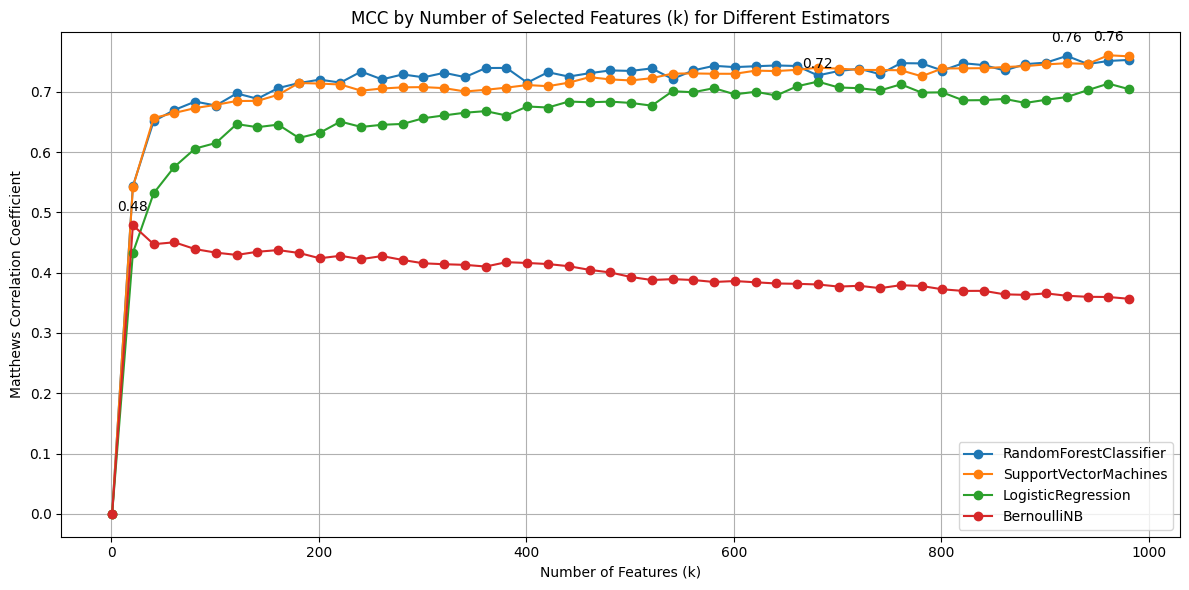

In [7]:
# Comparing MCC plots only

# Define the range of `k` values to explore
k_values = range(1, 1000, 20)

# Define estimators to compare
estimators = {
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'SupportVectorMachines': SVC(),
    'LogisticRegression': LogisticRegression(),
    'BernoulliNB': BernoulliNB()
}

# Prepare to store only MCC results
results = {name: {'mcc': []} for name in estimators}

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5)

# Loop over each estimator
for name, estimator in estimators.items():
    print(f"Processing estimator: {name}")
    for k in k_values:
        print(f"  Testing with k = {k}")
        pipeline = Pipeline([
            ('select_k', SelectKBest(f_classif, k=k)),
            ('estimator', estimator)
        ])
        mcc_scores = cross_val_score(
            pipeline, X_train, Y_train,
            cv=cv,
            scoring=make_scorer(matthews_corrcoef),
            n_jobs=-1
        )
        results[name]['mcc'].append(mcc_scores.mean())

# Plot only MCC
fig, ax = plt.subplots(figsize=(12, 6))
for name, info in results.items():
    ks   = list(k_values)
    mccs = info['mcc']
    ax.plot(ks, mccs, marker='o', linestyle='-', label=name)
    
    # annotate best MCC
    best_idx = np.nanargmax(mccs)
    best_k   = ks[best_idx]
    best_mcc = mccs[best_idx]
    ax.annotate(
        f'{best_mcc:.2f}',
        (best_k, best_mcc),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center'
    )

ax.set_title('MCC by Number of Selected Features (k) for Different Estimators')
ax.set_xlabel('Number of Features (k)')
ax.set_ylabel('Matthews Correlation Coefficient')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


Pearson Correlation Coefficient: 0.237


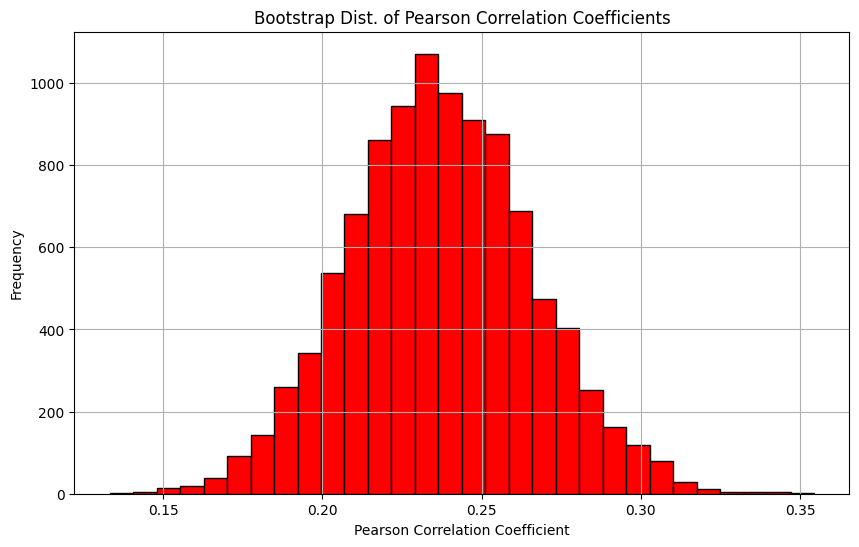

In [9]:
''' Pearson R for correlation coefficient between feature importance scores (From both models)'''


lr_model = LogisticRegression(solver='liblinear', penalty="l1")
rf_model = RandomForestClassifier(n_estimators=200, max_depth=100, min_samples_split=4, random_state=42)


lr_model.fit(X_aligned, Y_aligned)
rf_model.fit(X_aligned, Y_aligned)


logistic_importance = np.abs(lr_model.coef_[0])
rf_feature_importance = rf_model.feature_importances_

# Pearson correlation
pearson_corr, p_value = pearsonr(logistic_importance, rf_feature_importance)

print(f"Pearson Correlation Coefficient: {pearson_corr:.3f}")


# Bootstrap Pearson correlation coefficients
n_bootstraps = 10000
corr_coefficients = []

for _ in range(n_bootstraps):
    # Sample indices with replacement
    indices = resample(np.arange(len(logistic_importance)))
    
    # Calculate Pearson correlation for the sample
    r, _ = pearsonr(logistic_importance[indices], rf_feature_importance[indices])
    corr_coefficients.append(r)

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(corr_coefficients, bins=30, color='red', edgecolor='black')
plt.title('Bootstrap Dist. of Pearson Correlation Coefficients')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()